# Description
The purpose of this kernel is to explore the new TensorFlow 2.0 API to achieve the ML results fast and easily with efficiency optimizations built-in.
### Trying to automate the feature engineering and ensemble process. Both CPU and GPU compatible
### This kernel is by no means comprehensive and accurate but serve as a starting point. 
### I hope it will make some people's life easier in getting started with new TensorFlow version.
I will not be focussing on the utility provided by TensorFlow to convert old tf code to 2.0
### Will try to see if we can get away without extensively preprocessing the data and get tensorflow to handle the data types

In [1]:
# Utilities
import datetime
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import os
print(os.listdir("../input"))

# Numericals
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
%matplotlib inline

# TensorFlo 2.0
!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
# Imports for the HParams plugin from tensorboard
from tensorboard.plugins.hparams import api_pb2
from tensorboard.plugins.hparams import summary as hparams_summary
from google.protobuf import struct_pb2

# Clear any logs from previous runs
!rm -rf ./logs/ 

['test.csv', 'train.csv', 'gender_submission.csv']


In [2]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")
train_data.info()
print('_'*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         41

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Drop the columns if the missing values are more than 20% of the data. Drop missing rows otherwise

In [5]:
for col in train_data.columns:
    if len(train_data[col].dropna()) <= (0.7 * len(train_data)):
        train_data.drop(columns=[col], inplace=True)
    else:
        train_data.dropna(axis=0, subset=[col],inplace=True)

for col in test_data.columns:
    if len(test_data[col].dropna()) <= (0.7 * len(test_data)):
        test_data.drop(columns=[col], inplace=True)
    else:
        test_data[col].fillna(value=test_data[col].mode()[0] ,inplace=True)

In [6]:
train_data.info()
print('_'*50)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            712 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           41

## No need to convert the data types from categorical to numerical because we want tensorflow to handle this kind of data

## Define Feature columns for tensorflow
Examples of each column type

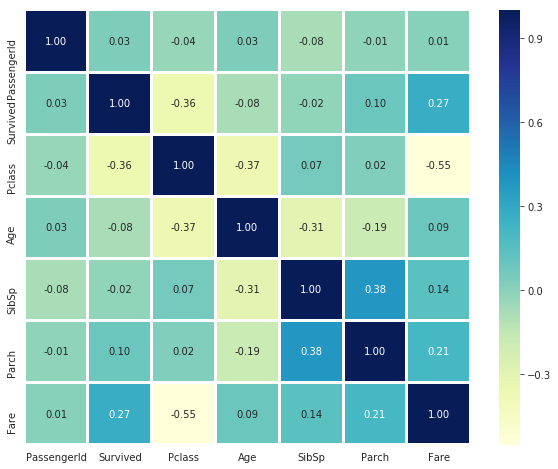

In [7]:
# Just to see the correlation
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(method='pearson'),annot=True,cmap='YlGnBu',fmt='.2f',linewidths=2)

In [8]:
feature_columns = []

# numeric cols
for header in ['Age', 'Fare']:
  feature_columns.append(tf.feature_column.numeric_column(header))

# bucketized cols
age = tf.feature_column.numeric_column("Age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[5, 10, 20, 30, 40, 50, 60, 70, 80])
feature_columns.append(age_buckets)

# indicator cols
categorical_cols = ["Sex", "Embarked", "Pclass", "SibSp", "Parch"]
for col in categorical_cols:
    train_data[col] = train_data[col].apply(str)
    test_data[col] = test_data[col].apply(str)
    cat_column_with_vocab = tf.feature_column.categorical_column_with_vocabulary_list(
          col, list(train_data[col].value_counts().index.values))
    one_hot = tf.feature_column.indicator_column(cat_column_with_vocab)
    feature_columns.append(one_hot)


# embedding cols
ticket = tf.feature_column.categorical_column_with_hash_bucket("Ticket", hash_bucket_size=1000)
ticket_embedding = tf.feature_column.embedding_column(ticket, dimension=8)
feature_columns.append(ticket_embedding)

# crossed cols
p_class = tf.feature_column.categorical_column_with_vocabulary_list(
          "Pclass", list(train_data["Pclass"].value_counts().index.values))
parch = tf.feature_column.categorical_column_with_vocabulary_list(
          "Parch", list(train_data["Parch"].value_counts().index.values))
pclass_parch_crossed = tf.feature_column.crossed_column([p_class, parch], hash_bucket_size=1000)
pclass_parch_crossed = tf.feature_column.indicator_column(pclass_parch_crossed)
feature_columns.append(pclass_parch_crossed)

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, testing=False, batch_size=32):
    dataframe = dataframe.copy()
    if not testing:
        labels = dataframe.pop('Survived')
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        ds = ds.shuffle(buffer_size=len(dataframe))
    else:
        ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
train_data, val_data = train_test_split(train_data, test_size=0.2)

In [11]:
batch_size = 32
train_ds = df_to_dataset(train_data, batch_size=batch_size)
val_ds = df_to_dataset(val_data, batch_size=batch_size)
test_ds = df_to_dataset(test_data, testing=True, batch_size=batch_size)

# Setup Hyperparameter tuning

In [12]:
num_units_list = [128, 256]
dropout_rate_list = [0.2, 0.5] 
optimizer_list = ['adam', 'sgd'] 

In [13]:
# Utility method to create summary for tensorboard
def create_experiment_summary(num_units_list, dropout_rate_list, optimizer_list):
  num_units_list_val = struct_pb2.ListValue()
  num_units_list_val.extend(num_units_list)
  dropout_rate_list_val = struct_pb2.ListValue()
  dropout_rate_list_val.extend(dropout_rate_list)
  optimizer_list_val = struct_pb2.ListValue()
  optimizer_list_val.extend(optimizer_list)
  return hparams_summary.experiment_pb(
      # The hyperparameters being changed
      hparam_infos=[
          api_pb2.HParamInfo(name='num_units',
                             display_name='Number of units',
                             type=api_pb2.DATA_TYPE_FLOAT64,
                             domain_discrete=num_units_list_val),
          api_pb2.HParamInfo(name='dropout_rate',
                             display_name='Dropout rate',
                             type=api_pb2.DATA_TYPE_FLOAT64,
                             domain_discrete=dropout_rate_list_val),
          api_pb2.HParamInfo(name='optimizer',
                             display_name='Optimizer',
                             type=api_pb2.DATA_TYPE_STRING,
                             domain_discrete=optimizer_list_val)
      ],
      # The metrics being tracked
      metric_infos=[
          api_pb2.MetricInfo(
              name=api_pb2.MetricName(
                  tag='accuracy'),
              display_name='Accuracy'),
      ]
  )

exp_summary = create_experiment_summary(num_units_list, dropout_rate_list, optimizer_list)
root_logdir_writer = tf.summary.create_file_writer("logs/hparam_tuning")
with root_logdir_writer.as_default():
  tf.summary.import_event(tf.compat.v1.Event(summary=exp_summary).SerializeToString())

In [14]:
# Model compiler
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns),
    tf.keras.layers.Dense(hparams['num_units'], activation='relu'),
    tf.keras.layers.Dropout(hparams['dropout_rate']),
      tf.keras.layers.Dense(hparams['num_units'], activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
  ])
  model.compile(optimizer=hparams['optimizer'],
                loss='binary_crossentropy',
                metrics=['accuracy'])

  model.fit(train_ds, 
            validation_data=val_ds, 
            epochs=50,
            use_multiprocessing=True,
            verbose=0)
  _, accuracy = model.evaluate(val_ds)
  return model, accuracy

In [15]:
# Model runner
def run(run_dir, hparams):
  writer = tf.summary.create_file_writer(run_dir)
  summary_start = hparams_summary.session_start_pb(hparams=hparams)

  with writer.as_default():
    model, accuracy = train_test_model(hparams)
    summary_end = hparams_summary.session_end_pb(api_pb2.STATUS_SUCCESS)
      
    tf.summary.scalar('accuracy', accuracy, step=1, description="The accuracy")
    tf.summary.import_event(tf.compat.v1.Event(summary=summary_start).SerializeToString())
    tf.summary.import_event(tf.compat.v1.Event(summary=summary_end).SerializeToString())
  return model, accuracy

In [16]:
model_dict = {}
session_num = 0
for num_units in num_units_list:
    for dropout_rate in dropout_rate_list:
        for optimizer in optimizer_list:
            hparams = {'num_units': num_units, 'dropout_rate': dropout_rate, 'optimizer': optimizer}
            print('--- Running training session %d' % (session_num + 1))
            print(hparams)
            run_name = "run-%d" % session_num
            model, accuracy = run("logs/hparam_tuning/" + run_name, hparams)
            print(accuracy)
            model_dict[accuracy] = model
            session_num += 1

W0313 06:17:39.373459 140040933365120 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:3048: HashedCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0313 06:17:39.378369 140040933365120 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0313 06:17:39.385691 140040933365120 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2902: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a fu

--- Running training session 1
{'num_units': 128, 'dropout_rate': 0.2, 'optimizer': 'adam'}
5/5 [==============================] - 0s 14ms/step - loss: 1.2814 - accuracy: 0.7203
0.7202797
--- Running training session 2
{'num_units': 128, 'dropout_rate': 0.2, 'optimizer': 'sgd'}
5/5 [==============================] - 0s 15ms/step - loss: 0.5749 - accuracy: 0.7098
0.7097902
--- Running training session 3
{'num_units': 128, 'dropout_rate': 0.5, 'optimizer': 'adam'}
5/5 [==============================] - 0s 14ms/step - loss: 1.1100 - accuracy: 0.7238
0.7237762
--- Running training session 4
{'num_units': 128, 'dropout_rate': 0.5, 'optimizer': 'sgd'}
5/5 [==============================] - 0s 13ms/step - loss: 0.5875 - accuracy: 0.7098
0.7097902
--- Running training session 5
{'num_units': 256, 'dropout_rate': 0.2, 'optimizer': 'adam'}
5/5 [==============================] - 0s 14ms/step - loss: 1.1513 - accuracy: 0.6993
0.6993007
--- Running training session 6
{'num_units': 256, 'dropout_rat

In [17]:
best_model = model_dict[max(list(model_dict.keys()))]

In [18]:
predictions = best_model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

In [19]:
predictions_dataframe = test_data[["PassengerId"]]
predictions_dataframe["Survived"] = predictions

In [20]:
predictions_dataframe.to_csv("gender_submission.csv",index=False)

In [21]:
best_model.save('best_model.h5')

# It is this easy to save the model in tensorflow now. Reload is the same - with weights :)